In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [88]:
# your code goes here
# load data
season = ""
episode = ""
scene = ""
data = []
with open("data/all_scripts.txt") as f:
    for line in f.readlines():
        line = line[:-1]
        #if line begin with >>
        if line.startswith(">>"):
            season = int(line[10:12])
            episode = line[3:]
            continue
        #if line begin with >
        if line.startswith(">"):
            scene = line[2:]
            continue
        character, line = line.split(": ", 1)
        data.append([season, episode, scene, character, line])
lines = pd.DataFrame(data, columns=["Season", "Episode", "Scene", "Character", "Line"])

display(lines.head())

,Season,Episode,Scene,Character,Line
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?"
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide..."
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,Hang on.


In [89]:
#count number of lines per scene

lines_per_scene = lines.groupby(["Season", "Episode", "Scene"]).count().reset_index().groupby("Season").count()[["Scene"]]

display(lines_per_scene)

,Scene
Season,
1,157
2,205
3,193
4,219
5,198
6,211
7,207
8,191
9,177


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [90]:
# your code goes here

characters = lines['Character'].unique()

#recurrent characters when character appears in more than 2 episodes
characters_by_episode = lines.groupby("Character").count()[["Episode", "Line"]]
display(characters_by_episode[characters_by_episode["Line"] > 90])

#remove character "Man"
characters_recurrent = characters_by_episode[characters_by_episode["Line"] > 90]
characters_recurrent.drop('Man')
characters_recurrent = characters_recurrent

display(characters_recurrent)
print("The number of reccurent characters: ", len(characters_recurrent))


,Episode,Line
Character,,
Amy,3472,3472
Arthur,130,130
Bernadette,2690,2690
Bert,95,95
Beverley,162,162
Emily,164,164
Howard,5872,5872
Kripke,106,106
Leonard,9829,9829


,Episode,Line
Character,,
Amy,3472,3472
Arthur,130,130
Bernadette,2690,2690
Bert,95,95
Beverley,162,162
Emily,164,164
Howard,5872,5872
Kripke,106,106
Leonard,9829,9829


The number of reccurent characters:  20


## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [91]:
lines_recurrent = lines[lines["Character"].isin(characters_recurrent.index)]

In [92]:
def clean_line(line):
    for char in EXCLUDE_CHARS:
        line = line.replace(char, ' ')
    return line.lower()
lines["Line"] = lines["Line"].apply(clean_line)
lines.head()

,Season,Episode,Scene,Character,Line
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,so if a photon is directed through a plane wit...
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,agreed what s your point
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,there s no point i just think it s a good ide...
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,excuse me
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,hang on


**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [93]:
# your code goes here
corpus_frequency =  pd.concat([pd.Series(row['Line'].split(' ')) for _, row in lines.iterrows()]).reset_index()
corpus_frequency.columns = ["index", "word"]
corpus_frequency = corpus_frequency.groupby("word").count()

display(corpus_frequency)

,index
word,
,136530
0,6
00,5
000,33
000lb,1
...,...
…tion,1
…when,1
…who,1


<Axes: title={'center': 'Word frequency distribution'}, ylabel='Frequency'>

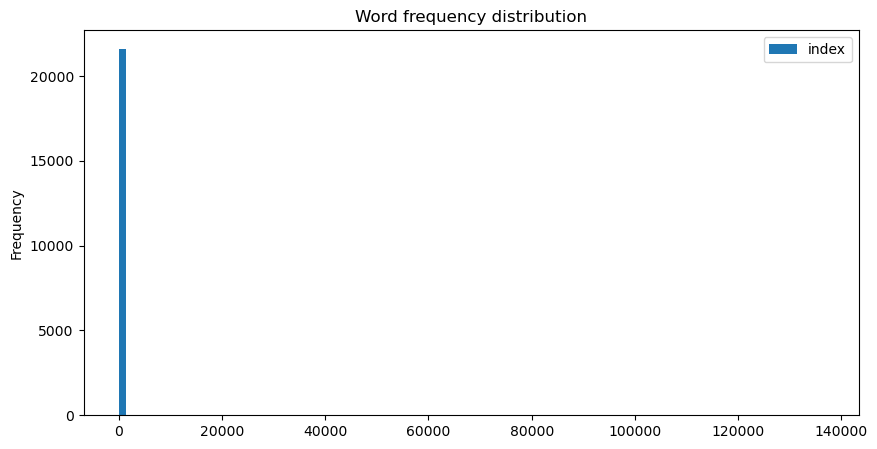

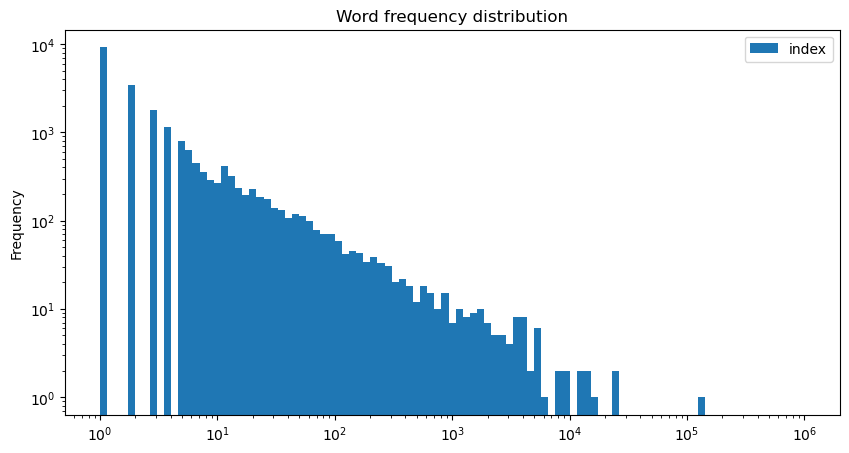

In [94]:
corpus_frequency.plot.hist(bins=100, figsize=(10, 5), title="Word frequency distribution")

corpus_frequency.plot.hist(bins=np.logspace(0, 6, 100), figsize=(10, 5), title="Word frequency distribution", loglog=True)

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [103]:
# your code goes here
#add a column with the number of words in each line
lines_recurrent["Word_count"] = lines_recurrent["Line"].apply(lambda x: len(x.split()))

characters_word_frequency = lines_recurrent.groupby("Character").sum()["Word_count"]

display(characters_word_frequency)

/var/folders/2f/7b8hf27x4j3bt73xqs0kvtch0000gn/T/ipykernel_94395/611775573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lines_recurrent["Word_count"] = lines_recurrent["Line"].apply(lambda x: len(x.split()))


Character
Amy              37384
Arthur            1353
Bernadette       25810
Bert              1065
Beverley          1918
Emily             1472
Howard           64988
Kripke            1163
Leonard          95608
Leslie            1164
Man               1162
Mrs Cooper        3205
Mrs Wolowitz      1364
Penny            74247
Priya             1824
Raj              56390
Sheldon         174911
Stuart            7407
Wil               1577
Zack              1336
Name: Word_count, dtype: int64

In [104]:
print("Most talkative character: ", characters_word_frequency[characters_word_frequency.index].idxmax())

Most talkative character:  Sheldon


## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [105]:
# your code goes here
train = lines_recurrent[lines_recurrent["Season"] <= 7]
test = lines_recurrent[lines_recurrent["Season"] > 7]

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [111]:
# your code goes here
#set of unique words in the training set
unique_words = set()
for _, row in train[train["Character"] != "Sheldon"].iterrows():
    unique_words.update(row["Line"].split())

unique_sheldon_words = set()
for _, row in train[train["Character"] == "Sheldon"].iterrows():
    unique_sheldon_words.update(row["Line"].split())

display(len(unique_words))
display(len(unique_sheldon_words))

25364

20696

In [112]:
#words only in unique_sheldon_words and not in unique_words
sheldon_unique_words = unique_sheldon_words.difference(unique_words)

display(len(sheldon_unique_words))

10605

In [114]:
#check in the test set if Sheldon uses these words

def sheldon_unique_words_in_test(line):
    for word in line.split():
        if word in sheldon_unique_words:
            return True
    return False

test_pred = test["Line"].apply(sheldon_unique_words_in_test)
test_true = test["Character"] == "Sheldon"

print("Accuracy: ", (test_true == test_pred).sum() / len(test_true))




Accuracy:  0.7569848851665248
